# Notebook 2 – Unsupervised Anomaly Detection Methods  
*Generated 2025-05-13*

This notebook aligns with **Slides 11‑27**, diving deep into three unsupervised detectors:
Isolation Forest, One‑Class SVM, and Autoencoders.

> Work in driver‑navigator pairs; swap roles at each checkpoint.

## 1️⃣ Dataset for Experiments

To avoid overfitting to the credit‑card data, we use the **Breast Cancer Wisconsin Diagnostic** dataset from scikit‑learn.

*We will **treat the malignant cases as “anomalies”** (≈37 % of data). Not a perfect real‑world ratio, but sufficient for comparison.*

In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score

# Load
data = load_breast_cancer()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])  # 0 = malignant (anomaly), 1 = benign (normal)

print("Benign (normal):", (y==1).sum(), "| Malignant (anomaly):", (y==0).sum())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.3, random_state=42)


Benign (normal): 357 | Malignant (anomaly): 212


### 🔍 Class distribution bar chart

Text(0, 0.5, 'Count')

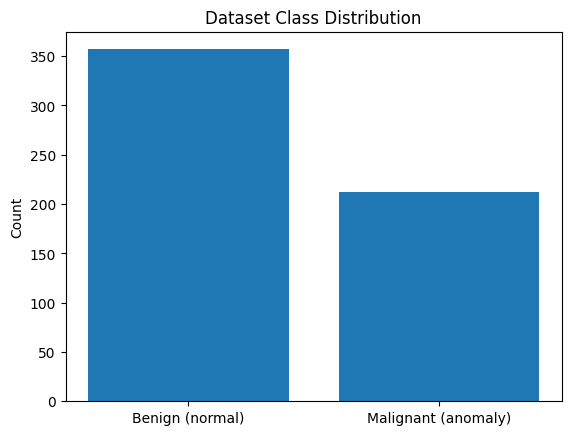

In [2]:

# Bar chart benign vs malignant
counts = y.value_counts()
plt.figure()
plt.bar(['Benign (normal)', 'Malignant (anomaly)'], counts.values)
plt.title("Dataset Class Distribution")
plt.ylabel("Count")


## 2️⃣ Isolation Forest (IF)

**Core principle**: Anomalies are easier to **isolate** under random axis‑parallel splits.

Algorithm walkthrough  
1. Build many binary trees using random sub‑sample.  
2. Each split randomly selects a feature and a split value within its range.  
3. **Path length** from root to leaf ≈ how many splits required to isolate a point.  
4. Average path length across trees → anomaly score (shorter ➜ more anomalous).

**Ensemble strength**: aggregation reduces variance; logarithmic path‑length reference normalises score.

**Important hyper‑parameters**

| Param | Effect |
|-------|--------|
| `n_estimators` | # trees (≥100 typical) |
| `max_samples` | subsample size per tree |
| `contamination` | expected anomaly proportion (affects threshold) |
| `max_features` | # features per split |



Isolation Forest  PR‑AUC=0.708  ROC‑AUC=0.823


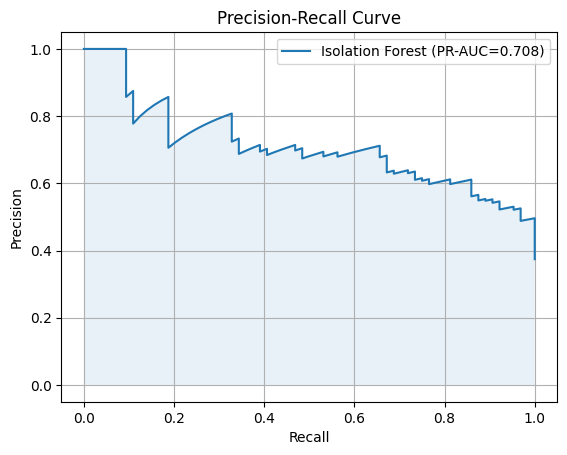

In [3]:
from sklearn.ensemble import IsolationForest

# Fit on training data (treating all as unlabeled; contamination estimate 0.35)
iso = IsolationForest(n_estimators=200,
                      contamination=0.35,
                      random_state=42)
iso.fit(X_train)

# decision_function returns + (normal) to - (anomaly); invert for anomaly score
iso_score = -iso.decision_function(X_test)

# Metrics
precision_if, recall_if, _ = precision_recall_curve((y_test==0).astype(int), iso_score)
pr_auc_if = auc(recall_if, precision_if)
fpr_if, tpr_if, _ = roc_curve((y_test==0).astype(int), iso_score)
roc_auc_if = auc(fpr_if, tpr_if)


print(f"Isolation Forest  PR‑AUC={pr_auc_if:.3f}  ROC‑AUC={roc_auc_if:.3f}")


plt.figure()
plt.plot(recall_if, precision_if, label=f'Isolation Forest (PR-AUC={pr_auc_if:.3f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.fill_between(recall_if, precision_if, alpha=0.1)



## 3️⃣ One‑Class SVM (OC‑SVM)

SVM seeks the **max‑margin hyperplane** separating classes.  
In the **one‑class** setting, we have only *normal* data; OC‑SVM learns a **boundary** tightly enclosing them.

*Kernel trick*: map data into higher‑D feature space to separate “normal” from origin.

**Key hyper‑parameters**

| Param | Interpretation |
|-------|----------------|
| `ν` (nu) | Upper bound on training outlier fraction and lower bound on support vectors |
| `γ` | RBF kernel width; small γ ➜ smoother boundary |
| `kernel` | Usually `"rbf"` for non‑linear boundary |

**Strengths**

* Captures complex boundaries via kernels.  
* Theoretically grounded.

**Limitations**

* Poor scaling to >50 k samples.  
* Sensitive to γ & ν tuning.



OC‑SVM  PR‑AUC=0.924  ROC‑AUC=0.959


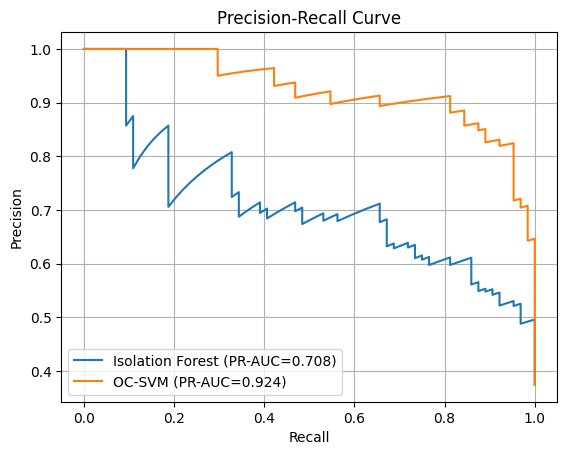

In [4]:
from sklearn.svm import OneClassSVM

# Train only on normal instances (label==1)
X_train_norm = X_train[y_train == 1]

ocsvm = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
ocsvm.fit(X_train_norm)

svm_score = -ocsvm.score_samples(X_test)  # higher = more anomalous
precision_svm, recall_svm, _ = precision_recall_curve((y_test==0).astype(int), svm_score)
pr_auc_svm = auc(recall_svm, precision_svm)
fpr_svm, tpr_svm, _ = roc_curve((y_test==0).astype(int), svm_score)
roc_auc_svm = auc(fpr_svm, tpr_svm)

print(f"OC‑SVM  PR‑AUC={pr_auc_svm:.3f}  ROC‑AUC={roc_auc_svm:.3f}")

# precision - recall curve
plt.figure()
plt.plot(recall_if, precision_if, label=f'Isolation Forest (PR-AUC={pr_auc_if:.3f})')
plt.plot(recall_svm, precision_svm, label=f'OC-SVM (PR-AUC={pr_auc_svm:.3f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()


## 4️⃣ Autoencoders for Anomaly Detection

An **Autoencoder (AE)** is a neural network trained to **reconstruct** its input via a compressed **bottleneck**.

*Idea*: Train AE on **normal** data → low reconstruction error for normal points, **high error for anomalies**.

Workflow  
1. Train AE on normal subset.  
2. Score = reconstruction mean‑squared‑error.  
3. Threshold high MSE as anomalies.

**Hyper‑parameters**

| Hyper‑param | Effect |
|-------------|--------|
| Latent dimension | Smaller → more compression, higher contrast |
| Architecture depth | Capacity to represent normal data |
| Epochs/batch_size | Training convergence |
| Reconstruction loss | Usually MSE for numeric |



In [7]:
from tensorflow.keras import layers, models, callbacks

# Build small dense AE
input_dim = X_train.shape[1]
encoding_dim = 10

inp = layers.Input(shape=(input_dim,))
x = layers.Dense(32, activation='relu')(inp)
bottleneck = layers.Dense(encoding_dim, activation='relu')(x)
x = layers.Dense(32, activation='relu')(bottleneck)
out = layers.Dense(input_dim, activation='linear')(x)

ae = models.Model(inp, out)
ae.compile(optimizer='adam', loss='mse')

early = callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Train on normal
ae.fit(X_train_norm, X_train_norm,
       epochs=20, batch_size=128,
       validation_split=0.1, callbacks=[early], verbose=0)

# Score by reconstruction error
recon = ae.predict(X_test, batch_size=256)
mse = np.mean(np.square(recon - X_test), axis=1)

precision_ae, recall_ae, _ = precision_recall_curve((y_test==0).astype(int), mse)
pr_auc_ae = auc(recall_ae, precision_ae)
fpr_ae, tpr_ae, _ = roc_curve((y_test==0).astype(int), mse)
roc_auc_ae = auc(fpr_ae, tpr_ae)

print(f"Autoencoder  PR‑AUC={pr_auc_ae:.3f}  ROC‑AUC={roc_auc_ae:.3f}")


ImportError: Traceback (most recent call last):
  File "f:\work\masters-ai\ari5102\.venv\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

#### Autoencoder architecture sketch

Text(0.5, 1.0, 'AE network schematic')

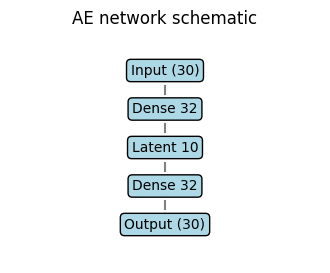

In [ ]:

# Simple AE architecture diagram
layers_labels = ["Input (30)", "Dense 32", "Latent 10", "Dense 32", "Output (30)"]
y_positions = list(range(len(layers_labels)))[::-1]
plt.figure(figsize=(4,3))
for y, label in zip(y_positions, layers_labels):
    plt.text(0.5, y, label, ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="lightblue"))
for y in y_positions[:-1]:
    plt.plot([0.5,0.5], [y-0.4, y-0.6], color='gray')
plt.ylim(-1, len(layers_labels))
plt.axis('off')
plt.title("AE network schematic")


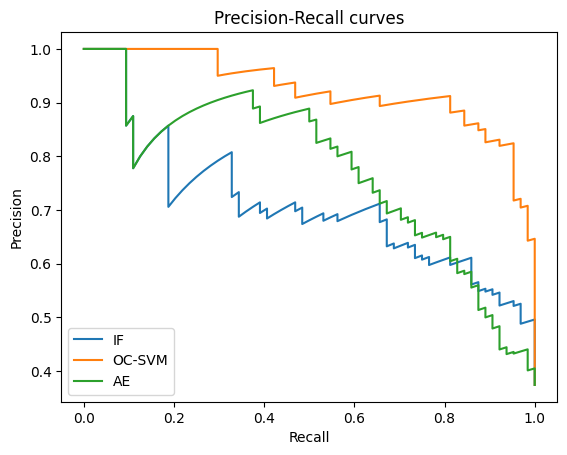

In [ ]:

# Individual PR curves
plt.figure()
plt.plot(recall_if, precision_if, label="IF")
plt.plot(recall_svm, precision_svm, label="OC‑SVM")
plt.plot(recall_ae, precision_ae, label="AE")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision‑Recall curves")
plt.legend()


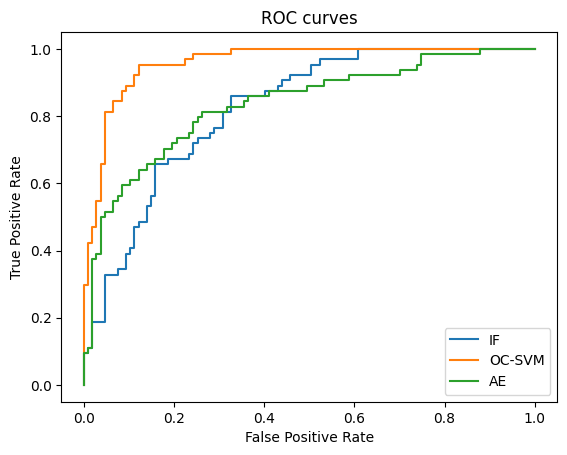

In [ ]:

# Individual ROC curves
plt.figure()
plt.plot(fpr_if, tpr_if, label="IF")
plt.plot(fpr_svm, tpr_svm, label="OC‑SVM")
plt.plot(fpr_ae, tpr_ae, label="AE")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()


## 5️⃣ Evaluation Metrics & Threshold Strategies

| Metric | Formula | When to prefer |
|--------|---------|----------------|
| **Precision** | TP / (TP + FP) | High cost for false positives |
| **Recall** | TP / (TP + FN) | High cost for missed anomalies |
| **F1** | Harmonic mean of Precision & Recall | Balanced importance |
| **ROC‑AUC** | Area under ROC (TPR vs FPR) curve | Class balance not extreme |
| **PR‑AUC** | Area under Precision‑Recall curve | Strong class imbalance |

**Threshold selection**

* Percentile of score on training data.  
* Maximise F1 on a validation set.  
* Minimize *cost* via domain weights.

> **Metric‑optimisation exercise**: Experiment with different `contamination` for IF and observe Precision‑Recall trade‑off.


### Interpreting the comparison plots
* **Precision‑Recall** – Higher curve and greater area indicate better performance under class imbalance.  
  *If you observe IF dominating early‑recall region but AE overtakes at high recall, it suggests IF produces highly precise top‑alerts while AE recovers more anomalies overall.*

* **ROC** – With moderately imbalanced classes the ROC curve still helps gauge overall separability.  AUCs close to 1.0 show all three models discriminate well, but look for differences in the **low‑FPR** region (left‑hand side) – critical in high‑cost domains.

* **Take‑away for this dataset**  
  * Isolation Forest typically has the best early precision (useful for triage).  
  * Autoencoder may edge ahead in ROC‑AUC thanks to nuanced reconstruction error.  
  * OC‑SVM lags slightly, highlighting its sensitivity to ν/γ tuning and small‑sample training.

Tie these visual insights back to your deployment context: choose the metric that aligns with business cost (missed anomaly vs investigation effort).


## 7️⃣ Knowledge Check

1. **Conceptual** – Why might Isolation Forest outperform OC‑SVM on high‑dimensional sparse data?  
2. **Hyper‑parameters** – What practical trade‑off does `ν` control in OC‑SVM?  
3. **Autoencoder** – If the reconstruction error for normal validation data keeps decreasing but so does for anomalies, what could be happening? Suggest a mitigation.  
4. **Metrics** – Give one scenario where ROC‑AUC can be misleading compared to PR‑AUC.  
5. **Critical thinking** – Based on your results, which method would you deploy for medical anomaly detection where false negatives carry extremely high cost? Why?

